# Uber Driver Data Analysis

(New version)

Works with SAR and Portal data.

Note that this notebook is not final, and more documentation is being added.

#### Installing the required libraries with pip

In [ ]:
! pip install jupyter numpy pandas portion pyexcelerate geopy

In [ ]:
import math
import os
import re
from configparser import ConfigParser
from typing import Callable, Any

import geopy.distance

from src.utils import *

#### Pipeline steps

In [ ]:
def time_tuples_to_periods(
        table: Table['t1': Timestamp, 't2': Timestamp, 't3': Timestamp],
        columns: list[str],
        extra_info: list[Callable[[pd.Series], dict]]
) -> pd.DataFrame:
    """
    Takes a dataframe where each row has N timestamps corresponding to instants of status changes,
    and converts each row into N-1 rows of periods in the corresponding status.

    :param: table: a table having a number N > 1 of time-columns and L of entries.
    :param: columns: a list of n time-column names present in {table}.
    :param: extra_info: a list of functions taking a row of df and outputting a dictionary of additional information. Cannot have keys 'begin' and 'end'.
    :return: periods: a table having L * (N-1) entries, each with a 'begin' and 'end' timestamp and associated information as specified by additional_info.
    Usage:
    df = pd.DataFrame([{'request_ts': '3:47 PM', 'begintrip_ts': '4:00 PM', 'dropoff_ts': '4:13 PM'}])
    columns = ['request_ts', 'begintrip_ts', 'dropoff_ts']
    extra_info = [lambda r: {'status': 'P2'}, lambda r: {'status': 'P3'}]
    time_tuples_to_periods(df, columns, extra_info)
    > begin    end      status
    > 3:47 PM  4:00 PM  P2
    > 4:00 PM  4:13 PM  P3
    """
    assert len(columns) == len(
        extra_info) + 1, f'The length of additional information should correspond to the number of generated periods (N-1).'
    periods = pd.DataFrame(table.apply(
        lambda r: [{'begin': r[b], 'end': r[e], **d(r)} for b, e, d in zip(columns, columns[1:], extra_info)],
        axis=1
    ).explode().to_list())
    return periods

In [ ]:
def load_lifetime_trips(zf: ZipFile, timezone: str, pattern: str = '*Driver Lifetime Trips.csv') -> PeriodTable:
    table = find_table(pattern, zf,
                       ['request_timestamp_utc', 'begintrip_timestamp_utc', 'dropoff_timestamp_utc', 'status',
                        'request_to_begin_distance_miles', 'trip_distance_miles', 'original_fare_local'])
    table = table[table.status == 'completed'].drop(columns='status')
    table.replace({r'\N': np.nan}, inplace=True)
    for col in ['request_timestamp_utc', 'begintrip_timestamp_utc', 'dropoff_timestamp_utc']:
        table[col] = pd.to_datetime(table[col], utc=True).dt.tz_convert(timezone)
    for col in ['request_to_begin_distance_miles', 'original_fare_local']:
        table[col] = table[col].astype(float)
    table = time_tuples_to_periods(
        table,
        columns=['request_timestamp_utc', 'begintrip_timestamp_utc', 'dropoff_timestamp_utc'],
        extra_info=[
            lambda r: {'status': 'P2', 'distance_km': mile2km(r['request_to_begin_distance_miles']), 'file': r['file']},
            lambda r: {'status': 'P3', 'distance_km': mile2km(r['trip_distance_miles']), 'file': r['file'],
                       'uber_paid': r['original_fare_local']}])
    return table

In [ ]:
def load_on_off(zf: ZipFile, timezone: str, pattern: str = '*Driver Online Offline.csv') -> PeriodTable:
    table = find_table(pattern, zf,
                       ['begin_timestamp_utc', 'end_timestamp_utc', 'earner_state',
                        'begin_lat', 'begin_lng', 'end_lat', 'end_lng'])
    table.rename(columns={'begin_timestamp_utc': 'begin', 'end_timestamp_utc': 'end',
                          'earner_state': 'status'}, inplace=True)
    table = table.replace({r'\N': np.nan, 'ontrip': 'P3', 'enroute': 'P2', 'open': 'P1', 'offline': 'P0'})
    table = table[table.status != 'P3']
    gps_cols = ['begin_lat', 'begin_lng', 'end_lat', 'end_lng']
    for col in gps_cols:
        table[col] = table[col].astype(float)
    for col in ['begin', 'end']:
        table[col] = pd.to_datetime(table[col], utc=True).dt.tz_convert(timezone)
    table = table.dropna()
    table['distance_km'] = table.apply(
        lambda r: geopy.distance.geodesic((r['begin_lat'], r['begin_lng']), (r['end_lat'], r['end_lng'])).km, axis=1)
    table.drop(columns=gps_cols, inplace=True)
    return table.dropna()

In [ ]:
def load_sar(zip_path: Path, timezone: str = 'Europe/Zurich') -> Table:
    with ZipFile(zip_path) as zf:
        print(f'Zip open')
        lifetime_trips = load_lifetime_trips(zf, timezone)
        on_off = load_on_off(zf, timezone)
    print(f'Zip closed')
    return pd.concat([lifetime_trips, on_off]).reset_index(drop=True)

#### Portal preprocessing

In [ ]:
def load_portal(zip_path: Path, timezone: str = 'Europe/Zurich'):
    with ZipFile(zip_path) as zf:
        print(f'Zip open')
        table = find_table('*driver_lifetime_trips*.csv', zf,
                           ['Status', 'Local Request Timestamp', 'Begin Trip Local Timestamp',
                            'Local Dropoff Timestamp',
                            'Trip Distance (miles)', 'Duration (Seconds)', 'Local Original Fare'])
    print(f'Zip closed')
    table = table[table['Status'] == 'completed']
    for col in ['Local Request Timestamp', 'Begin Trip Local Timestamp', 'Local Dropoff Timestamp']:
        table[col] = pd.to_datetime(table[col]).dt.tz_convert(timezone)
    table = time_tuples_to_periods(
        table, columns=['Local Request Timestamp', 'Begin Trip Local Timestamp', 'Local Dropoff Timestamp'],
        extra_info=[lambda r: {'status': 'P2'},
                    lambda r: {'status': 'P3', 'distance_km': mile2km(r['Trip Distance (miles)']),
                               'uber_paid': r['Local Original Fare']}])
    return table

#### Driver-specific logic

In [ ]:
def guillaume_filtering_logic(
        daily: Table,
        percentage_df_path: Optional[str | Path] = None
) -> Table:
    filtered = pd.DataFrame(index=daily.index)
    filtered['datetime'] = pd.to_datetime(daily['date'])
    duration_P1_cols = list(filter(lambda col: all(f in col for f in ['duration_h', 'P1']), daily.columns))
    # First, weight P1 times based on the percentage that Guillaume was working for Uber on that month
    if percentage_df_path is not None:
        percentage = pd.read_csv(percentage_df_path)
        percentage['Uber'] /= 100
        for c in duration_P1_cols:
            for i, row in percentage.iterrows():
                filtered[c] = np.where(
                    (filtered.datetime.dt.year == row.year) & (filtered.datetime.dt.month == row.month),
                    daily[c] * row['Uber'], daily[c])

    # Second, remove all morning weekday entries when Guillaume was working for IMAD, except for the specific dates below
    dates_to_keep = [dt.date(2020, 11, 26), *date_range((2020, 12, 21), (2020, 12, 25)),
                     *date_range((2021, 2, 1), (2021, 2, 12)), *date_range((2021, 8, 16), (2021, 8, 28)),
                     *date_range((2021, 9, 20), (2021, 10, 3)), *date_range((2021, 11, 25), (2021, 12, 12)),
                     *date_range((2022, 4, 25), (2022, 5, 13))]
    duration_P1_weekday_AM_cols = list(
        filter(lambda col: all(f in col for f in ['duration_h', 'P1', 'AM', 'weekday']), daily.columns))
    filtered.loc[
        daily[~filtered.datetime.apply(lambda d: d.date()).isin(dates_to_keep)].index, duration_P1_weekday_AM_cols] = 0
    return filtered[duration_P1_cols].rename(columns={col: f'{col}(filtered)' for col in duration_P1_cols})

### Main pipeline steps

The next method merges intervals according to the following logic:

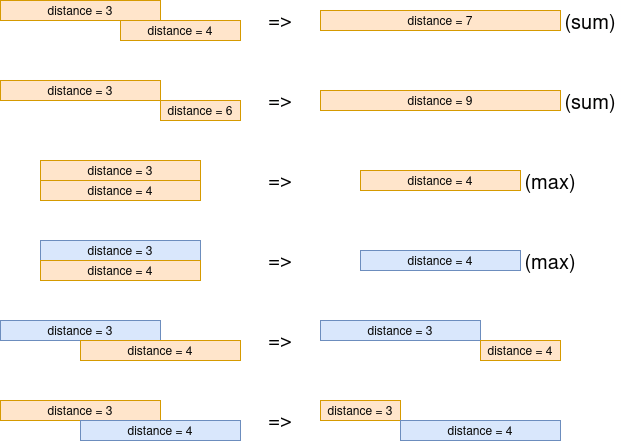

Here, the blue status has a higher priority than the orange one (e.g. blue = P3 > P2 = orange).

Note that the sum and max logic could be customized per attribute (possible for the sum part but not the max one at the moment).

In [ ]:
def merge_overlapping_intervals(table: PeriodTable, agg_dict: Optional[dict] = None) -> PeriodTable:
    """
    Merges overlapping entries "efficiently".
    :param table: the table whose intervals should be merged
    :param agg_dict: maps each row to the operation that should be applied to combine interval attributes when merging them
    :return: a table with merged intervals
    """
    agg_dict = agg_dict or {c: sum for c in all_facets if c != 'duration_h'}

    status_in_order: list['str'] = ['P3', 'P2', 'P1', 'unavailable', 'P0']
    priority: dict[str, int] = dict(zip(status_in_order, range(len(status_in_order), 0, -1)))
    table = table.sort_values(['begin', 'end'])
    groups: list[dict] = []
    group: dict = table.iloc[0].to_dict()
    for i, row in table.iloc[1:].iterrows():
        # Group and row overlap
        if row['begin'].astimezone(dt.timezone.utc) <= group['end'].astimezone(dt.timezone.utc):
            # TODO make this part more understandable
            if (row['begin'], row['end']) == (group['begin'], group['end']):  # Exactly the same interval
                if priority[row['status']] > priority[group['status']]:
                    group['status'] = row['status']
                group.update({c: max([group[c], row[c]]) for c, f in agg_dict.items()})
            else:
                if row['status'] == group['status']:
                    group.update(begin=min(row['begin'], group['begin']), end=max(row['end'], group['end']))
                    group.update({c: f([group[c], row[c]]) for c, f in agg_dict.items()})
                else:  # different statuses
                    if priority[row['status']] > priority[group['status']]:
                        group['end'] = row['begin']
                    else:
                        row['begin'] = group['end']
                    groups.append(group)
                    group = row.to_dict()
        else:
            groups.append(group)
            group = row.to_dict()

    return pd.DataFrame.from_records(groups)

In [ ]:
def split_hours(table: PeriodTable) -> PeriodTable:
    """
    Splits intervals spanning many hours periods in as many intervals as hours covered by the interval.
    If the interval is associated to numerical values (like distance or money), these values are
    transferred to the new intervals but are weighted according to the new intervals' duration.
    :param table: the table whose intervals should be split
    :return: a table with no intervals spanning over AM and PM
    """

    def f(begin: Timestamp, end: Timestamp, **rest) -> list[dict]:
        og_tz = begin.tzinfo
        begin = begin.astimezone(dt.timezone.utc)
        end = end.astimezone(dt.timezone.utc)
        og_duration = end - begin
        # Check if the interval spans many days, and split into as many days as it spans
        rows = []
        if begin.hour != end.hour or begin.day != end.day:
            rows.append(scaled_interval(begin, begin.replace(minute=59, second=59), rest, og_duration))
            for hours in range(1, math.floor((end - begin) / dt.timedelta(hours=1)) - 1):
                mid = begin + dt.timedelta(hours=hours)
                rows.append(scaled_interval(mid.replace(minute=0, second=0),
                                            mid.replace(minute=59, second=59), rest, og_duration))
            rows.append(scaled_interval(end.replace(minute=0, second=0), end, rest, og_duration))
        else:
            rows.append({'begin': begin, 'end': end, **rest})
        return [{**{k: ts.astimezone(og_tz) for k, ts in select(d, keep=['begin', 'end']).items()},
                 **select(d, drop=['begin', 'end'])} for d in rows]

    return pd.DataFrame([e for d in table.to_dict('records') for e in f(**d)])

### Running the pipeline

In [ ]:
all_facets = ['duration_h', 'distance_km', 'uber_paid']
all_time_properties: dict[str, Callable[[Timestamp], Any]] = {
    'day_of_week': lambda d: d.day_name(),
    'day_type': lambda d: 'weekday' if d.weekday() < 5 else 'weekend',
    'time_of_day': lambda d: 'AM' if d.hour < 12 else 'PM',
    'night': lambda d: 'night' if d.hour <= 6 or 23 < d.hour else 'day'
}

In [ ]:
def pipeline(
        periods: PeriodTable,
        save_folder: Path,
        interval_logic: Optional[Callable[[PeriodTable], PeriodTable]] = None,
        filtering_logic: Optional[Callable[[PeriodTable], PeriodTable]] = None,
        time_properties: Optional[dict[str, Callable[[Timestamp], Any]]] = None,
        name: str = 'analysis',
        facets: list[str] = all_facets,
        compute_most_lucrative_months: bool = True
):

    # Apply interval logic if specified
    if interval_logic is not None:
        periods = interval_logic(periods)
    # Split intervals spanning many hours
    periods = split_hours(periods)
    # Compute the duration of each split period
    periods['duration_h'] = (periods.end.dt.tz_convert('UTC') - periods.begin.dt.tz_convert('UTC')) / dt.timedelta(
        hours=1)

    # Compute these datetime properties since they will be the same for begin and end (thanks to split_hours)
    periods['hour'] = periods.end.apply(lambda d: f'{d.hour}-{(d + dt.timedelta(hours=1)).hour}')
    periods['date'] = periods.end.dt.date.astype(str)
    periods['week'] = periods.end.apply(find_week_limits)
    periods['month'] = periods.end.apply(lambda d: f'{d.month:02d}. {d.month_name()}')
    periods['year'] = periods.end.dt.year

    pivoting_cols = ['status']
    if time_properties:
        for k, f in time_properties.items():
            periods[k] = periods.end.apply(f)
        pivoting_cols += list(time_properties.keys())
    # Pivot table so that each there is a single line per interval and per granularity of interest
    # TODO Note: this should be pivot and not pivot_table, but there are (begin, end, status) duplicates in the data
    # TODO which shouldn't happen, so the duplicates are merged by averaging other values but it doesn't make sense.
    periods = periods.pivot_table(index=['begin', 'end', 'hour', 'date', 'week', 'month', 'year'],
                                  columns=pivoting_cols, values=facets, aggfunc='max',
                                  margins_name='total').reset_index()
    # Next 2 lines remove columns that have only 0/nans
    periods[periods == 0] = np.nan
    periods.drop(columns=periods.columns[periods.isna().all()], inplace=True)
    # Merges column multiindex into a single index by joining the levels
    periods.columns = periods.columns.map(lambda t: '.'.join(t) if t[1] else t[0])

    agg_dict = {c: sum for c in periods.columns if any(f in c for f in facets)}

    tabs = {'periods': periods,
            'hourly': periods.groupby(['date', 'hour']).agg(agg_dict).reset_index(),
            'daily': periods.groupby(['date', 'year', 'month', 'week']).agg(agg_dict).reset_index()}

    # Filter the data if a filtering function is specified
    if filtering_logic is not None:
        filtered = filtering_logic(tabs['daily'])
        tabs['daily'] = pd.concat([tabs['daily'], filtered], axis=1)
        agg_dict = {**agg_dict, **{c: sum for c in filtered.columns}}

    tabs['weekly'] = tabs['daily'].groupby(['week']).agg(agg_dict).reset_index()
    tabs['monthly'] = tabs['daily'].groupby(['year', 'month']).agg(agg_dict).reset_index()
    tabs['yearly'] = tabs['daily'].groupby(['year']).agg(agg_dict).reset_index()
    tabs['total'] = tabs['yearly'].agg(agg_dict).to_frame().T
    tabs['daily'].drop(columns=['year', 'month'], inplace=True)

    save_folder.mkdir(parents=True, exist_ok=True)
    if compute_most_lucrative_months:
        print('Computing lucrative months')
        df = tabs['monthly'].copy()
        df['uber_paid_total'] = df[[c for c in df.columns if 'uber_paid' in c]].sum(axis=1)
        df = df.sort_values('uber_paid_total', ascending=False)
        tabs['most_lucrative_months'] = df
        request_months = list(df.iloc[:10].sort_values(['year', 'month']).apply(
            lambda r: f'{french_months[int(r.month.split(".")[0])]} {r.year}', axis=1))
        request_months += list(
            filter(lambda s: s not in request_months, [f'{french_months[i]} 2020' for i in range(3, 12 + 1)]))
        tabs['sar_request_text'] = pd.DataFrame(
            [{'text': sar_text.replace('{REPLACE_HERE}', ', '.join(request_months))}])

    print('Writing Excel file')
    save_excel(save_folder / f'{name}_results.xlsx', tabs, float_format='.2f')
    print('Done!')

In [ ]:
def run_from_config():
    config = ConfigParser()
    config.read(filenames='config.ini')
    for section in re.split(',\s*', config.get('global', 'run')):
        in_path = config.get(section, 'input_zipfile')
        out_path = config.get(section, 'output_folder')
        timezone = config.get(section, 'timezone')
        facets = re.split(',\s*', config.get(section, 'facets'))
        time_properties = select(all_time_properties, re.split(',\s*', config.get(section, 'time_properties')))

        match config.get(section, 'type'):
            case 'SAR':
                loader = load_sar
            case 'Portal':
                loader = load_portal
            case other:
                raise ValueError(f'[{section}].type must be specified and be one of SAR or Portal. Found "{other}"')

        print(f"{'-' * 20} Running {section} {'-' * 20}")
        periods = loader(in_path, timezone)
        pipeline(periods, interval_logic=merge_overlapping_intervals, save_folder=Path(out_path), name=section,
                 facets=facets, time_properties=time_properties)

In [ ]:
def run_all_zips_in_folder(data_folder: Path = Path(os.getcwd()) / 'data', ignore: list[str] = []):
    for filename in os.listdir(data_folder):
        if filename.endswith('.zip'):
            name = filename.split('.zip')[0]
            if filename in ignore:
                continue
            if 'SAR' in name:
                loader = load_sar
            elif 'Portal' in name:
                loader = load_portal
            else:
                print(name)
                continue

            print(f"{'-' * 20} Running {filename} {'-' * 20}")
            periods = loader(data_folder / filename)
            pipeline(periods, interval_logic=merge_overlapping_intervals, save_folder=data_folder / 'results',
                     name=name,
                     facets=all_facets, time_properties=all_time_properties)

In [ ]:
run_from_config()